In [1]:
from u_net import *
from tools import *
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision

plt.style.use('Style_graph.mplstyle')
plt.rcParams['text.usetex'] = False

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [2]:
image_dir= '../Dataset/images'
mask_dir = '../Dataset/masks'
img_size = (128, 128)

x_train, y_train = load_data(image_dir, mask_dir, img_size= img_size)
print(x_train.shape, y_train.shape)

(1454, 128, 128, 1) (1454, 128, 128, 1)


In [3]:
image_test_dir= '../Dataset/image - test'
mask_test_dir = '../Dataset/masks - test'
img_size = (128, 128)

x_test, y_test = load_data(image_test_dir, mask_test_dir, img_size= img_size)
print(x_test.shape, y_test.shape)

(300, 128, 128, 1) (300, 128, 128, 1)


In [4]:
data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.30, # Evitar treinar apenas com celulas centralizadas 
    height_shift_range=0.30,
    #shear_range=0.1,
    #zoom_range=0.1,
    #brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True
)

mask_data_gen_args = dict(
    rotation_range=15,
    width_shift_range=0.30,
    height_shift_range=0.30,
    #shear_range=0.1,
    #zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_data_gen_args)

In [5]:
batch_size = 16

image_generator = image_datagen.flow(
    x_train.astype('float32'),
    batch_size=batch_size,
    seed=42,
    shuffle=True
)

mask_generator = mask_datagen.flow(
    y_train.astype('float32'),
    batch_size=batch_size,
    seed=42,
    shuffle=True
)


In [6]:
def generator():
    while True:
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        mask_batch = np.where(mask_batch > 0.5, 1, 0).astype('float32') # Binarizar as mascaras

        yield img_batch, mask_batch

train_generator = generator()
validation_data = (x_test, y_test)

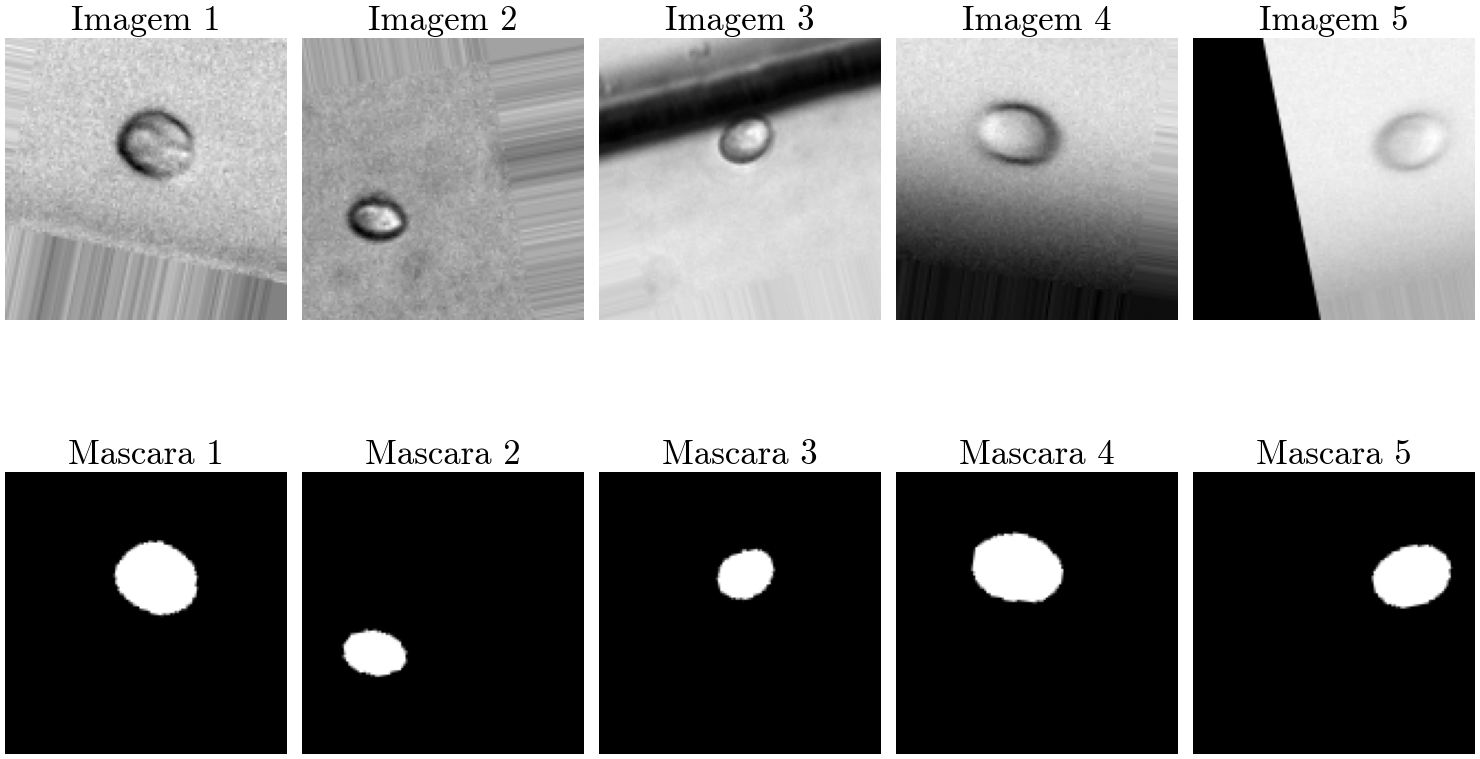

In [8]:
def plot_images_and_masks(image_generator, mask_generator, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)

        img = img_batch[0, :, :, 0] # (batch_size, height, width, channels)
        mask = mask_batch[0, :, :, 0]
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Imagem {i + 1}")
        plt.axis('off')

        
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mascara {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plotar 5 amostras de imagens e máscaras transformadas
plot_images_and_masks(image_generator, mask_generator, num_samples=5)

In [9]:
model = unet_reduzida()
model.compile(optimizer = Adam(learning_rate=1e-4), loss = dice_loss, metrics=[dice_coefficient])

In [10]:
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience = 8,
    mode='max',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coefficient',
    factor=0.1,
    patience=5,
    min_lr=1e-6)

In [11]:
steps_per_epoch = len(x_train) // batch_size
history = model.fit(
          train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data= validation_data,
          epochs= 200,
          callbacks=[early_stopping, reduce_lr]
          )

Epoch 1/200
90/90 [==============================] - 15s 104ms/step - loss: 0.5800 - dice_coefficient: 0.4204 - val_loss: 0.2823 - val_dice_coefficient: 0.7097 - lr: 1.0000e-04
Epoch 2/200
90/90 [==============================] - 7s 74ms/step - loss: 0.2285 - dice_coefficient: 0.7716 - val_loss: 0.2336 - val_dice_coefficient: 0.7648 - lr: 1.0000e-04
Epoch 3/200
90/90 [==============================] - 7s 77ms/step - loss: 0.1686 - dice_coefficient: 0.8315 - val_loss: 0.2082 - val_dice_coefficient: 0.7960 - lr: 1.0000e-04
Epoch 4/200
90/90 [==============================] - 7s 76ms/step - loss: 0.1484 - dice_coefficient: 0.8516 - val_loss: 0.1013 - val_dice_coefficient: 0.8987 - lr: 1.0000e-04
Epoch 5/200
90/90 [==============================] - 7s 77ms/step - loss: 0.1224 - dice_coefficient: 0.8776 - val_loss: 0.0842 - val_dice_coefficient: 0.9158 - lr: 1.0000e-04
Epoch 6/200
90/90 [==============================] - 7s 77ms/step - loss: 0.1102 - dice_coefficient: 0.8898 - val_loss: 0.0

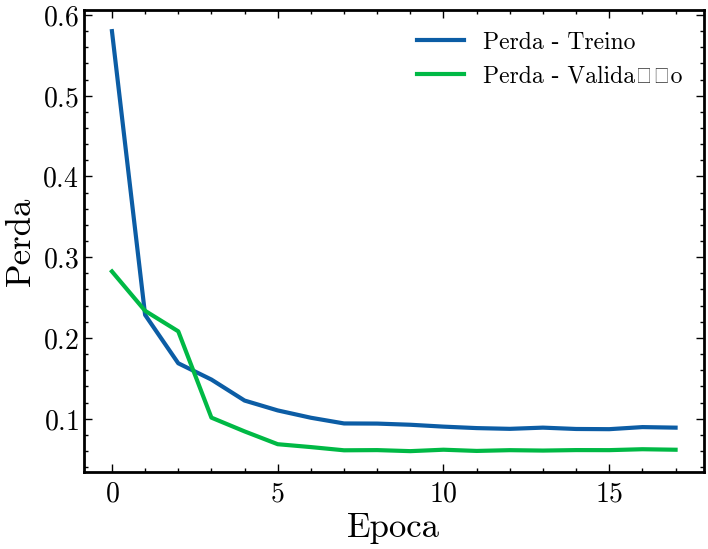

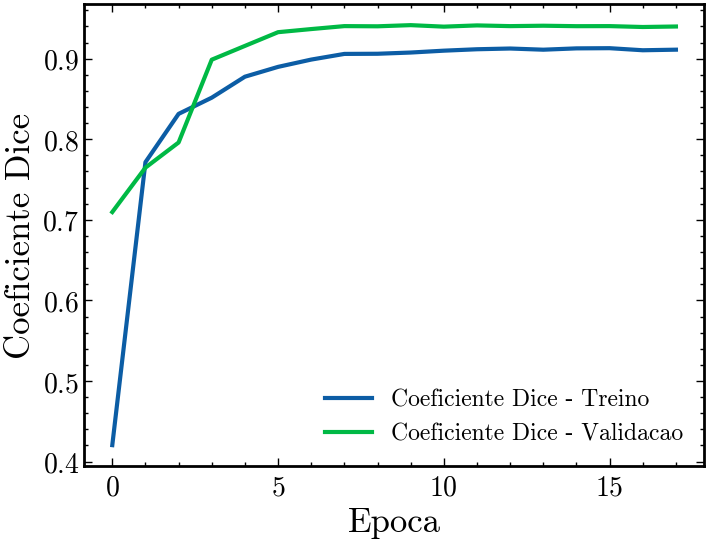

In [40]:



plt.plot(history.history['loss'], label='Perda - Treino')
plt.plot(history.history['val_loss'], label='Perda - Validação')

plt.xlabel('Epoca')
plt.ylabel('Perda')
plt.legend()
plt.show()



plt.plot(history.history['dice_coefficient'], label='Coeficiente Dice - Treino')
plt.plot(history.history['val_dice_coefficient'], label='Coeficiente Dice - Validacao')
plt.xlabel('Epoca')
plt.ylabel('Coeficiente Dice')
plt.legend()
plt.show()


10/10 [==============================] - 1s 81ms/step


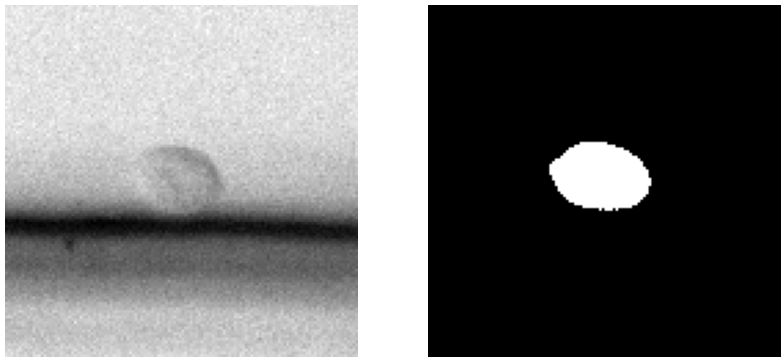

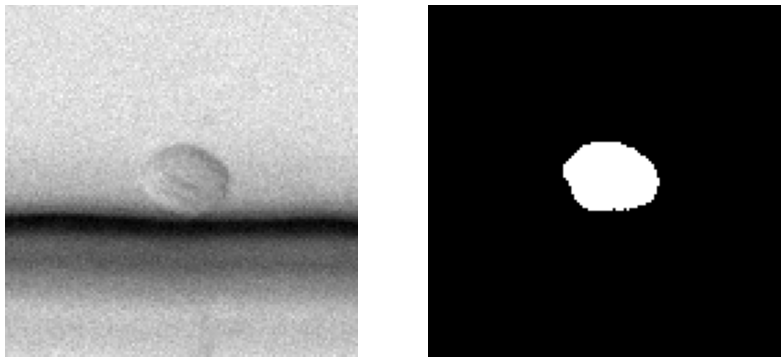

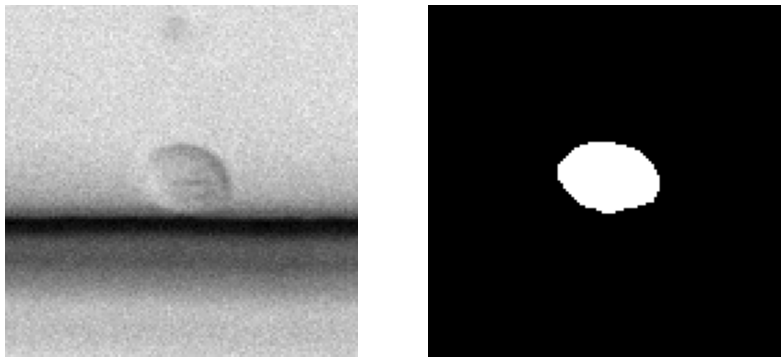

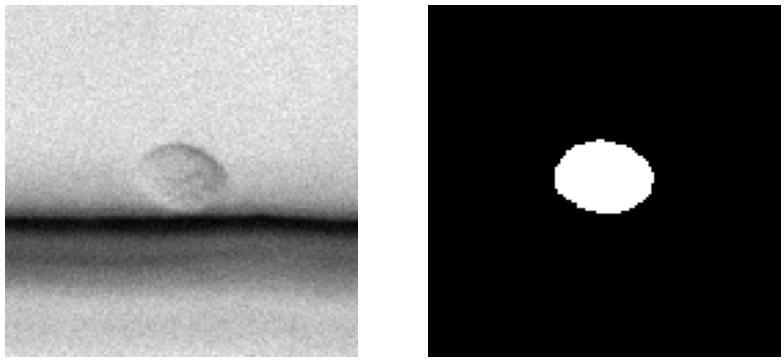

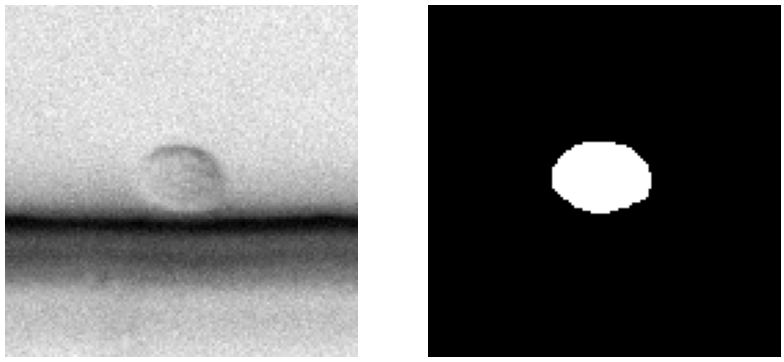

In [27]:
predictions = model.predict(x_test)

num_images = 5 
threshold = 0.3 

for i in range(num_images):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[2]), cmap='gray')
    plt.axis('off')

    binary_mask = (predictions[i] > threshold).astype(np.uint8)
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask.reshape(x_test.shape[1], x_test.shape[2]), cmap='gray')
    plt.axis('off')

    plt.show()


10/10 [==============================] - 1s 75ms/step


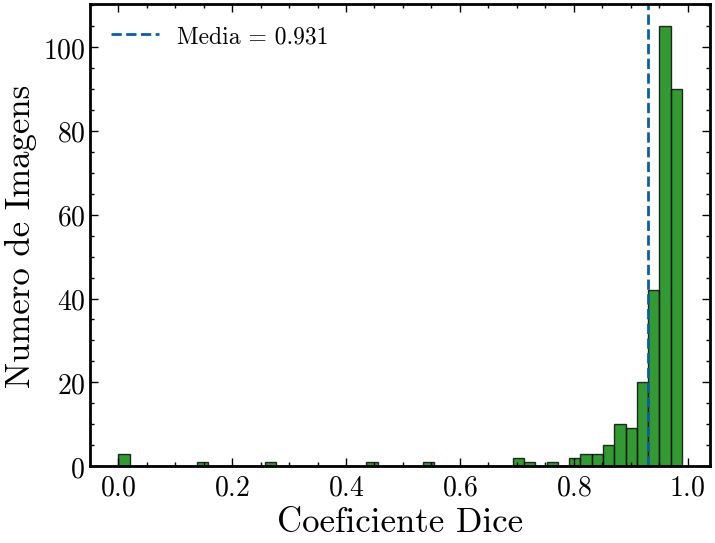

In [49]:
y_pred = model.predict(x_test)
y_pred_bin = (y_pred > 0.5).astype(np.float32)

dice_scores = []

for i in range(len(x_test)):
    y_true = y_test[i]
    y_hat  = y_pred_bin[i]

    intersection = np.sum(y_true * y_hat)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_hat) + 1e-7)

    dice_scores.append(dice)


dice_scores = np.array(dice_scores)

dice_mean = dice_scores.mean()
dice_std  = dice_scores.std()

plt.hist(dice_scores, bins=50, edgecolor='black', alpha=0.8, color='green')
plt.axvline(dice_mean, linestyle='--', linewidth=2, label=f'Media = {dice_mean:.3f}')

plt.xlabel('Coeficiente Dice')
plt.ylabel('Numero de Imagens')
plt.legend()
plt.show()



In [60]:
val_dice = history.history['val_dice_coefficient']

best_dice = np.max(val_dice)
best_epoch = np.argmax(val_dice) + 1   # +1 porque época começa em 1

print(f'Melhor Dice de validação: {best_dice:.4f}')
print(f'Época correspondente: {best_epoch}')

Melhor Dice de validação: 0.9416
Época correspondente: 10


In [61]:
val_loss = history.history['val_loss']

best_loss = np.min(val_loss)
best_loss_epoch = np.argmin(val_loss) + 1

print(f'Menor loss validação: {best_loss:.4f}')
print(f'Época correspondente: {best_loss_epoch}')

Menor loss validação: 0.0598
Época correspondente: 10


In [14]:
#model.save(
   #"model_seg_128x128-0.90",
   #save_format="tf"
#)